Epoch 1/50


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6159 - loss: 0.6702 - val_accuracy: 0.5224 - val_loss: 0.6771
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6949 - loss: 0.5943 - val_accuracy: 0.5779 - val_loss: 0.5660
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7043 - loss: 0.5604 - val_accuracy: 0.6274 - val_loss: 0.5042
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7405 - loss: 0.5249 - val_accuracy: 0.6659 - val_loss: 0.5112
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7962 - loss: 0.4842 - val_accuracy: 0.7158 - val_loss: 0.4605
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8219 - loss: 0.4504 - val_accuracy: 0.7000 - val_loss: 0.4848
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8454 - loss: 0.4108 - val_accuracy: 0.7650 - val_loss: 0.3827
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8592 - loss: 0.3831 - val_accuracy: 0.7471 - val_

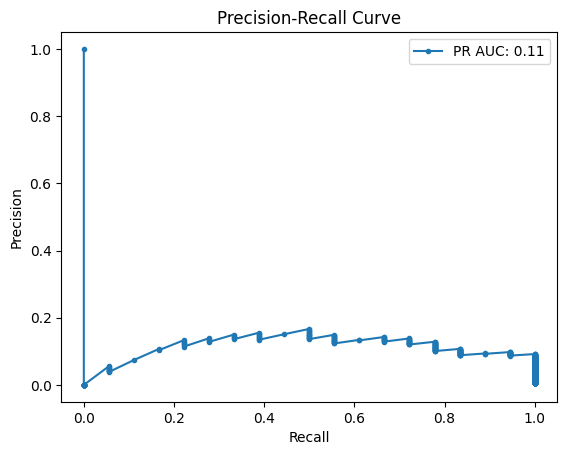

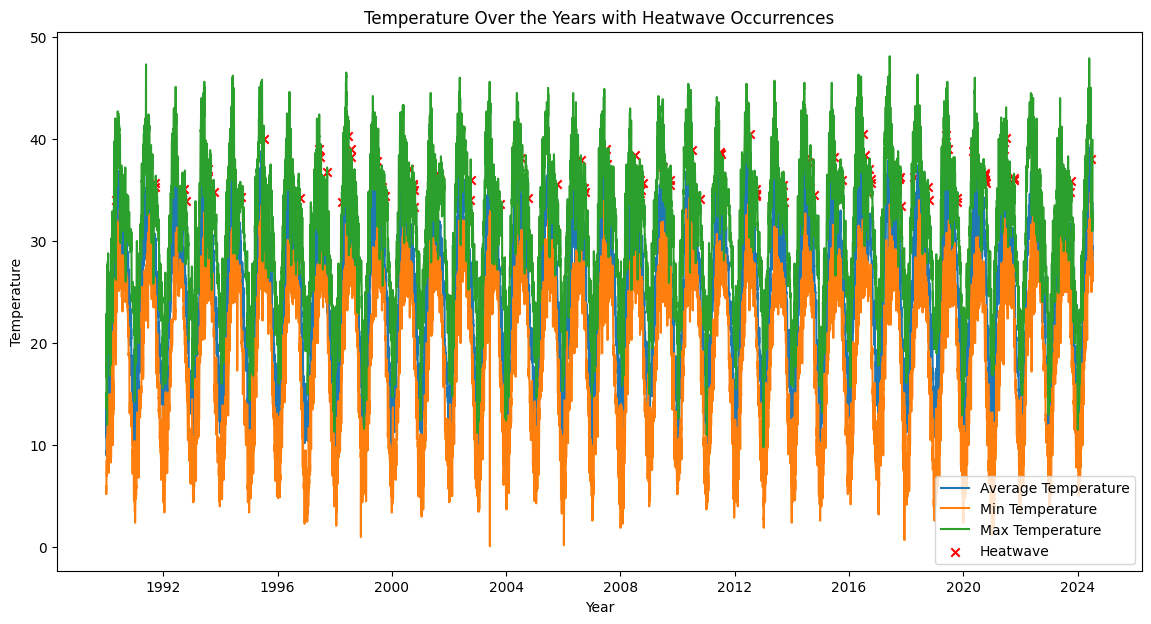

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] == 60:
        return 1  # Heatwave due to high temperature and 100% humidity
    elif row['tmax'] > threshold_temp and row['humid'] > 100:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
print(classification_report(y_test, y_pred))

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Calculate the area under the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, marker='.', label=f'PR AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Function to predict heatwave for a given date based on historical data
def predict_heatwave(date_str):
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
    except ValueError:
        return "Invalid date format. Please use YYYY-MM-DD."
    
    # Using the average of historical data as a placeholder for prediction
    avg_tavg = df['tavg'].mean()
    avg_tmin = df['tmin'].mean()
    avg_tmax = df['tmax'].mean()
    avg_humid = df['humid'].mean()
    
    sample = np.array([[avg_tavg, avg_tmin, avg_tmax, avg_humid]])
    sample_scaled = scaler.transform(sample)
    sample_scaled = sample_scaled.reshape((1, 1, sample_scaled.shape[1]))
    prediction_prob = model.predict(sample_scaled)
    prediction = (prediction_prob > 0.5).astype(int)
    return "Heatwave" if prediction == 1 else "No Heatwave"

# Plot temperature over the years with heatwave occurrences marked
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['tavg'], label='Average Temperature')
plt.plot(df['time'], df['tmin'], label='Min Temperature')
plt.plot(df['time'], df['tmax'], label='Max Temperature')

# Mark heatwave occurrences with a cross
heatwave_dates = df[df['Heatwave'] == 1]['time']
heatwave_temps = df[df['Heatwave'] == 1]['tmax']
plt.scatter(heatwave_dates, heatwave_temps, color='red', marker='x', label='Heatwave')

plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Temperature Over the Years with Heatwave Occurrences')
plt.legend()
plt.show()

# Interactive user input for heatwave prediction
while True:
    date_str = input("Enter a date (YYYY-MM-DD) to predict heatwave or 'exit' to quit: ")
    if date_str.lower() == 'exit':
        break
    prediction = predict_heatwave(date_str)
    print(f'Prediction for {date_str}: {prediction}')


Epoch 1/100


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.5018 - loss: 0.6929 - val_accuracy: 0.2572 - val_loss: 0.6961
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6082 - loss: 0.6922 - val_accuracy: 0.1609 - val_loss: 0.6997
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5732 - loss: 0.6914 - val_accuracy: 0.1625 - val_loss: 0.7023
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5773 - loss: 0.6907 - val_accuracy: 0.1792 - val_loss: 0.7042
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5859 - loss: 0.6900 - val_accuracy: 0.2057 - val_loss: 0.7057
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5977 - loss: 0.6892 - val_accuracy: 0.2255 - val_loss: 0.7068
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6080 - loss: 0.6886 - val_accuracy: 0.2556 - val_loss: 0.7075
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6166 - loss: 0.6879 - val_accuracy: 0.2743 - val_loss: 0.7081
Epo

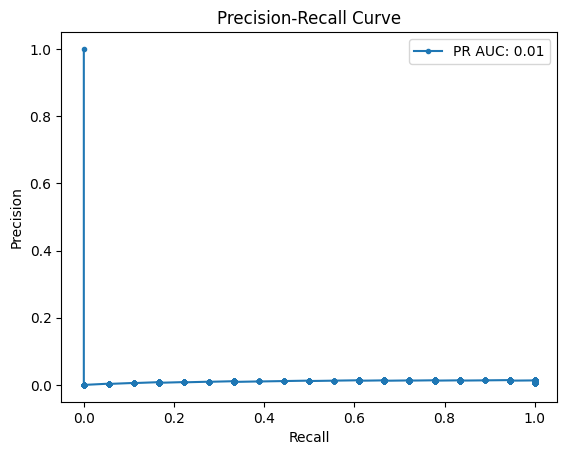

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')
# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] == 60:
        return 1  # Heatwave due to high temperature and 100% humidity
    elif row['tmax'] > threshold_temp and row['humid'] > 100:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)
# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)
# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=10000, validation_data=(X_test, y_test), class_weight=class_weights_dict)
# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
print(classification_report(y_test, y_pred))

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Calculate the area under the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, marker='.', label=f'PR AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()



Epoch 1/500


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5580 - loss: 0.6869 - val_accuracy: 0.3801 - val_loss: 0.7269
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7022 - loss: 0.6558 - val_accuracy: 0.5339 - val_loss: 0.6729
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7396 - loss: 0.6198 - val_accuracy: 0.5719 - val_loss: 0.6405
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7004 - loss: 0.5989 - val_accuracy: 0.5632 - val_loss: 0.6251
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6804 - loss: 0.5952 - val_accuracy: 0.5458 - val_loss: 0.6282
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6881 - loss: 0.5820 - val_accuracy: 0.5608 - val_loss: 0.5907
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6788 - loss: 0.5745 - val_accuracy: 0.5283 - val_loss: 0.6206
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6973 - loss: 0.5682 - val_accuracy: 0.5188

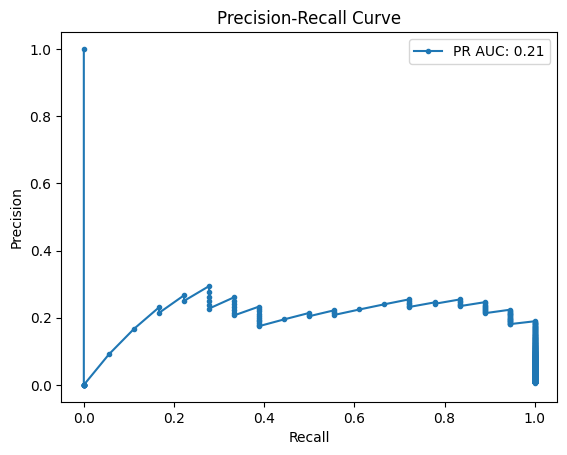

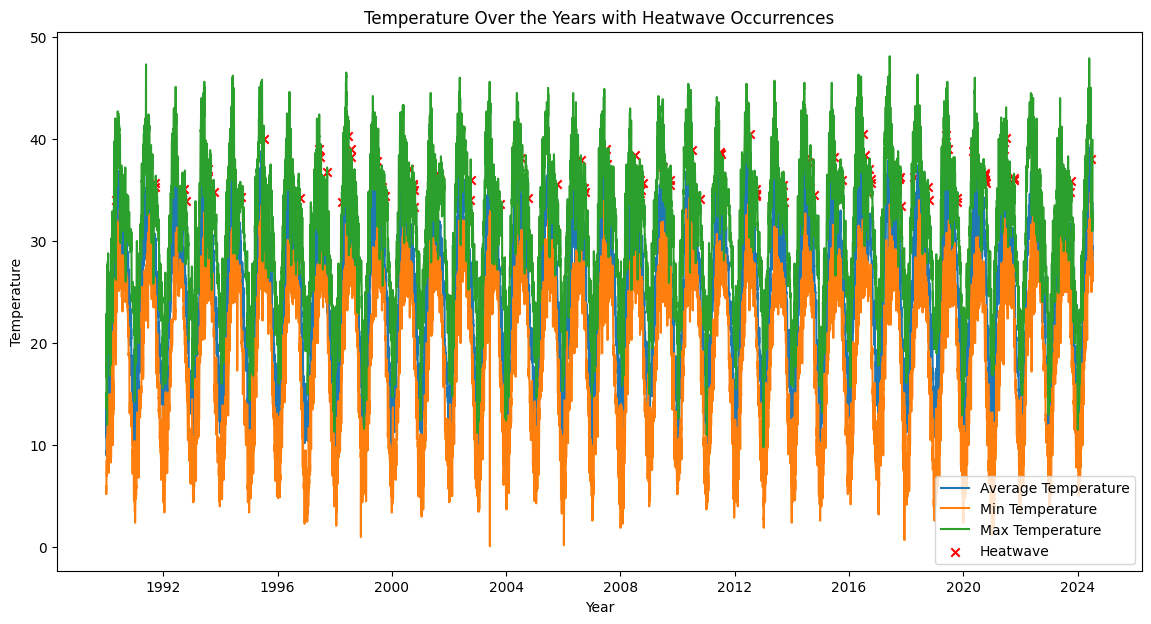

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] == 60:
        return 1  # Heatwave due to high temperature and 100% humidity
    elif row['tmax'] > threshold_temp and row['humid'] > 100:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
model.fit(X_train_resampled, y_train_resampled, epochs=500, batch_size=100, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
print(classification_report(y_test, y_pred))

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Calculate the area under the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, marker='.', label=f'PR AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Function to predict heatwave for a given date based on historical data
def predict_heatwave(date_str):
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
    except ValueError:
        return "Invalid date format. Please use YYYY-MM-DD."
    
    # Using the average of historical data as a placeholder for prediction
    avg_tavg = df['tavg'].mean()
    avg_tmin = df['tmin'].mean()
    avg_tmax = df['tmax'].mean()
    avg_humid = df['humid'].mean()
    
    sample = np.array([[avg_tavg, avg_tmin, avg_tmax, avg_humid]])
    sample_scaled = scaler.transform(sample)
    sample_scaled = sample_scaled.reshape((1, 1, sample_scaled.shape[1]))
    prediction_prob = model.predict(sample_scaled)
    prediction = (prediction_prob > 0.5).astype(int)
    return "Heatwave" if prediction == 1 else "No Heatwave"

# Plot temperature over the years with heatwave occurrences marked
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['tavg'], label='Average Temperature')
plt.plot(df['time'], df['tmin'], label='Min Temperature')
plt.plot(df['time'], df['tmax'], label='Max Temperature')

# Mark heatwave occurrences with a cross
heatwave_dates = df[df['Heatwave'] == 1]['time']
heatwave_temps = df[df['Heatwave'] == 1]['tmax']
plt.scatter(heatwave_dates, heatwave_temps, color='red', marker='x', label='Heatwave')

plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Temperature Over the Years with Heatwave Occurrences')
plt.legend()
plt.show()

# Interactive user input for heatwave prediction
while True:
    date_str = input("Enter a date (YYYY-MM-DD) to predict heatwave or 'exit' to quit: ")
    if date_str.lower() == 'exit':
        break
    prediction = predict_heatwave(date_str)
    print(f'Prediction for {date_str}: {prediction}')
